# AR-MA

In [21]:
# Imports
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import ccf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from ipynb.fs.full.stationarity import run_sequence_plot
np.random.seed(0) # For reproducibility

## Autoregressive (AR) models

  - An Autoregressive (AR) model is a type of time series model that uses observations from previous time steps as input to a regression equation to predict the value at the next time step.
  - The AR model is dependent solely on its own past values.
  

- The general form of an AR model of order $p$ is:

$$X(t) = c + \phi_1 X(t-1) + \phi_2 X(t-2) + \dots + \phi_p X(t-p) + \epsilon_t$$

- where
    - $X(t)$: Time series value at time $t$.
    - $c$: Constant term (also known as the intercept).
    - $\phi_1, \phi_2, \dots, \phi_p$: Coefficients of the model.
    - $p$: Order of the AR model (number of lag terms).
    - $\epsilon_t$: Error term (white noise) at time $t$.

**AR(1) Model**
- The first-frder autoregressive model, AR(1), is

$$X(t) = c + \phi_1 X(t-1) + \epsilon_t$$

- In an AR(1) model, the current value is based on the immediately preceding value.
> Example: A simple stock price model where today's price is partially dependent on yesterday's price.

**Higher Order AR Models**
- Higher order AR models (AR(2), AR(3), etc.) depend on more than one past value.
- For example, the AR(2) model is:

$$X(t) = c + \phi_1 X(t-1) + \phi_2 X(t-2) + \epsilon_t$$

- These models are useful in scenarios where the effect of more than one previous time step is significant.

**Limitations of AR Models**
- AR models require the time series to be **stationary**.
- Higher order AR models can *overfit* the training data and perform bad in prediction.
- They cannot model non-linear relationships in the data.

### AR model forcasting

- How do we determine the correct order $p$ of the AR model?
- We do that by looking at the first lags of the PACF.
- Let's see it through an example.

In [6]:
ar_data = arma_generate_sample(ar=np.array([1.0, -0.5, 0.7]), ma=np.array([1]), nsample=200, scale=1, burnin=1000)

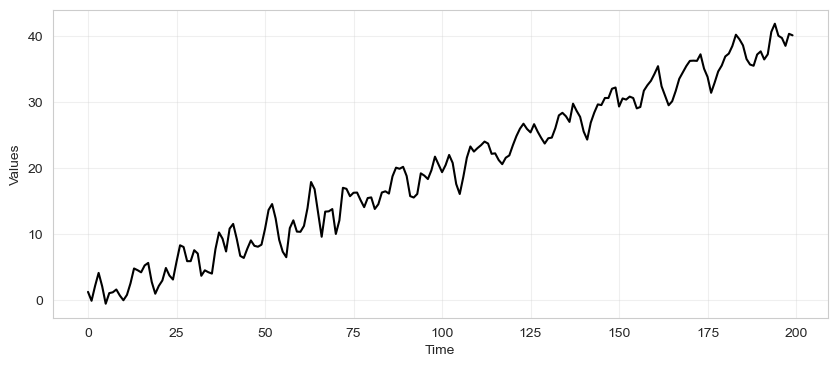

In [7]:
time = np.arange(200)
trend = time * 0.2
seasonality = 2*np.sin(2*np.pi*time/12) # Seasonality 12
time_series_ar = trend + seasonality + ar_data

_, ax = plt.subplots(1, 1, figsize=(10, 4))
run_sequence_plot(time, time_series_ar, "", ax=ax);

In [8]:
train_data_ar = time_series_ar[:164]
test_data_ar = time_series_ar[164:]

In [9]:
# Trend differencing
diff_ar = train_data_ar[1:] - train_data_ar[:-1]

# Seasonal differencing (assume period to be 12)
diff_diff_ar = diff_ar[12:] - diff_ar[:-12]

# check the confidence of stationarity using Augmented Dickey-Fuller (ADF) statistic (p-value<0.05)
_, pvalue, _, _, _, _ = adfuller(diff_diff_ar)
print(f"p-value: {pvalue:.3f}")

p-value: 0.000


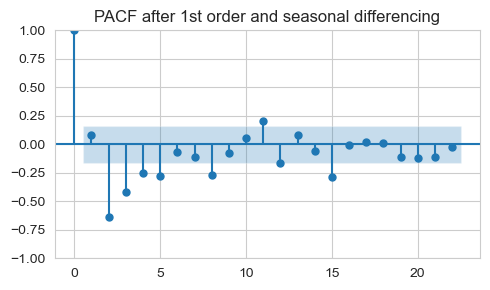

In [10]:
_, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_pacf(diff_diff_ar, ax=ax, title="PACF after 1st order and seasonal differencing")
plt.tight_layout() # lag=2 will be selected

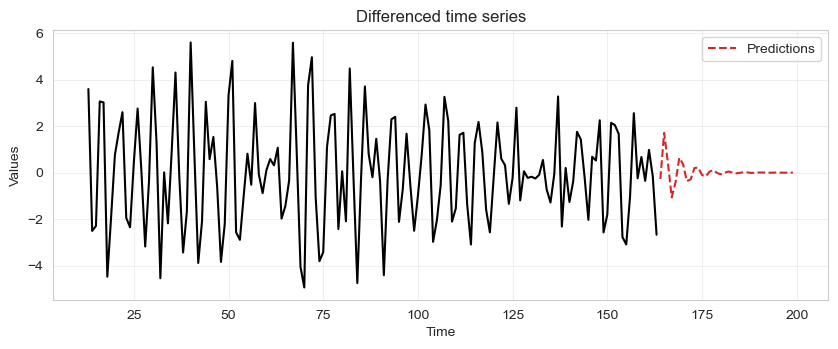

In [11]:
# Fit the model
model = ARIMA(diff_diff_ar, order=(2,0,0))
model_fit = model.fit()

# Compute predictions
diff_preds = model_fit.forecast(steps=len(test_data_ar))

ax = run_sequence_plot(time[13:len(train_data_ar)], diff_diff_ar, "")
ax.plot(time[len(train_data_ar):], diff_preds, label='Predictions', linestyle='--', color='tab:red')
plt.title('Differenced time series')
plt.legend()

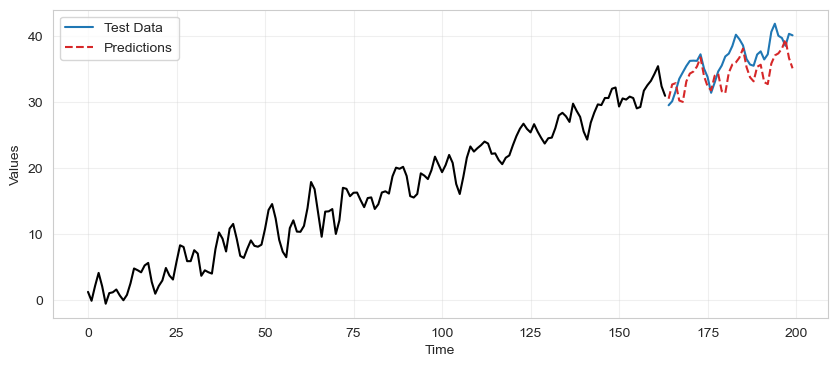

In [12]:
# Reintegrating the seasonal differencing
reintegrated_seasonal = np.zeros(len(test_data_ar))
reintegrated_seasonal[:12] = diff_ar[-12:] + diff_preds[:12]
for i in range(12, len(test_data_ar)):
    reintegrated_seasonal[i] = reintegrated_seasonal[i-12] + diff_preds[i]

# Reintegrating 1st order differencing
reintegrated_ar = reintegrated_seasonal.cumsum() + train_data_ar[-1]

_, ax = plt.subplots(1, 1, figsize=(10, 4))
run_sequence_plot(time[:len(train_data_ar)], train_data_ar, "", ax=ax)
ax.plot(time[len(train_data_ar):], test_data_ar, label='Test Data', color='tab:blue')
ax.plot(time[len(train_data_ar):], reintegrated_ar, label='Predictions', linestyle='--', color='tab:red')
plt.legend()

---

In [13]:
mse_differencing = mean_squared_error(test_data_ar, reintegrated_ar)
print(f"MSE of differencing: {mse_differencing:.2f}")

MSE of differencing: 8.03


## Moving Average (MA) models

- The MA model is a linear regression of the current value of the series against the white noise of one or more of the previous values of the series.
- **MA is designed to smooth out fluctuations.**

- The MA model is defined as

$$X(t) = \mu + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \dots + \theta_q \epsilon_{t-q}$$

- where:
    - $X(t)$: Time series value at time $t$.
    - $\mu$: Mean of the series.
    - $\theta_1, \theta_2, \dots, \theta_q$: Coefficients of the model.
    - $q$: Order of the MA model (number of lagged error terms).
    - $\epsilon_t$: Error term (white noise) at time $t$.

- MA models capture the dependency between an observation and a residual error through a moving average applied to lagged observations.
- Fitting MA estimates is more complicated than AR models because the error terms are not observable.
- Therefore, iterative nonlinear fitting procedures need to be used.
- MA models are less interpretable than AR models.
- As AR models, also MA models require data to be **stationary**.

### MA model forcasting

In [14]:
ma = np.array([1.0, 0.7, 0.8])  # MA parameters
ma_data = arma_generate_sample(np.array([1]), ma, nsample=len(time), scale=1, burnin=1000) # MA process

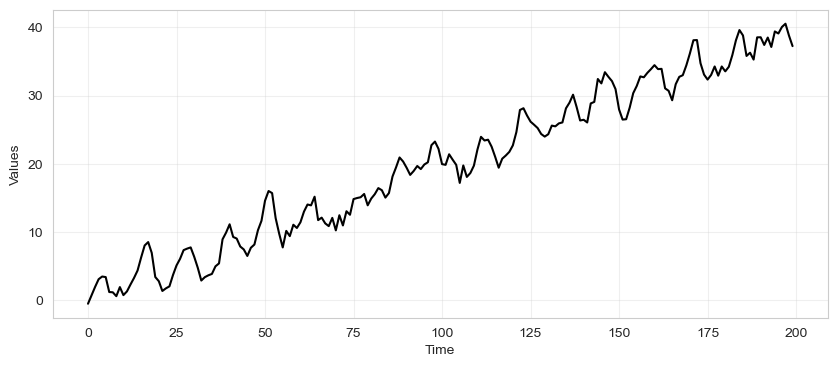

In [15]:
time_series_ma = trend + seasonality + ma_data
_, ax = plt.subplots(1, 1, figsize=(10, 4))
run_sequence_plot(time, time_series_ma, "", ax=ax);

In [16]:
# Train/test split
train_data_ma = time_series_ma[:164]
test_data_ma = time_series_ma[164:]

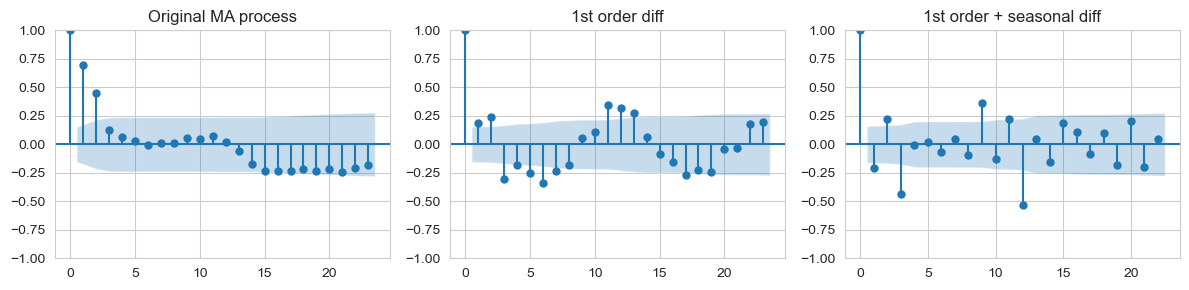

In [17]:
diff_ma = train_data_ma[1:] - train_data_ma[:-1]
diff_diff_ma = diff_ma[12:] - diff_ma[:-12]

_, axes = plt.subplots(1,3, figsize=(12, 3))
plot_acf(ma_data[:len(train_data_ma)], ax=axes[0], title="Original MA process")
plot_acf(diff_ma, ax=axes[1], title="1st order diff")
plot_acf(diff_diff_ma, ax=axes[2], title="1st order + seasonal diff")
plt.tight_layout();

- The ACF obtained after seasonal differencing suggests order $p=3$

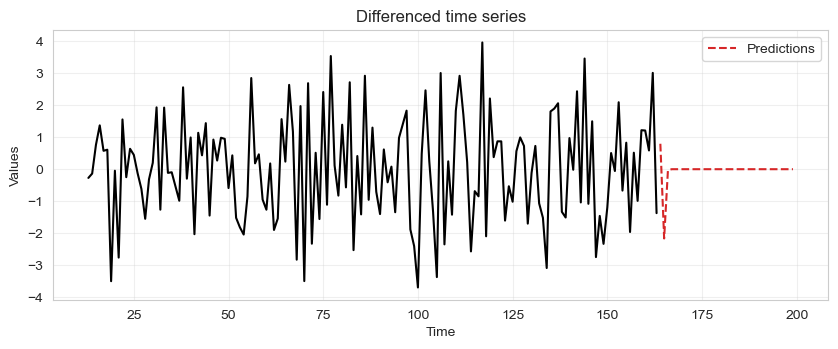

In [18]:
# Fit the model
model = ARIMA(diff_diff_ma, order=(0,0,3))
model_fit = model.fit()

# Compute predictions
diff_preds = model_fit.forecast(steps=len(test_data_ma))

ax = run_sequence_plot(time[13:len(train_data_ma)], diff_diff_ma, "")
ax.plot(time[len(train_data_ma):], diff_preds, label='Predictions', linestyle='--', color='tab:red')
plt.title('Differenced time series')
plt.legend();

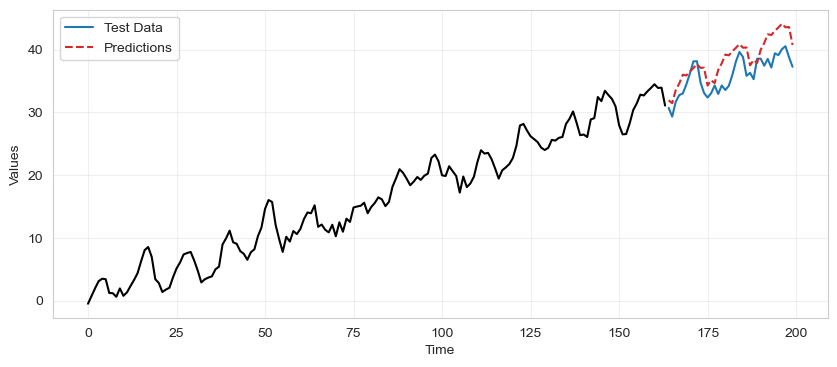

In [19]:
# Reintegrating the seasonal differencing
reintegrated_seasonal = np.zeros(len(test_data_ma))
reintegrated_seasonal[:12] = diff_ma[-12:] + diff_preds[:12]
for i in range(12, len(test_data_ma)):
    reintegrated_seasonal[i] = reintegrated_seasonal[i-12] + diff_preds[i]

# Reintegrating 1st order differencing
reintegrated_ma = reintegrated_seasonal.cumsum() + train_data_ma[-1]

_, ax = plt.subplots(1, 1, figsize=(10, 4))
run_sequence_plot(time[:len(train_data_ma)], train_data_ma, "", ax=ax)
ax.plot(time[len(train_data_ma):], test_data_ma, label='Test Data', color='tab:blue')
ax.plot(time[len(train_data_ma):], reintegrated_ma, label='Predictions', linestyle='--', color='tab:red')
plt.legend()

In [20]:
mse_differencing = mean_squared_error(test_data_ma, reintegrated_ma)
print(f"MSE of differencing: {mse_differencing:.2f}")

MSE of differencing: 9.49


---

## Summary

### AR vs MA Models

| **AR Models** | **MA Models** |
|:--------------|:--------------|
|Depend on past values of the series. | Depend on past forecast errors. |
| Suitable when past values have a direct influence on future values and for slowly changing time series | Useful when the series is better explained by shocks or random disturbances, i.e., time series with sudden changes|
| If the **PACF** drops sharply at a given lag $p$ or the first lag autocorrelation is **positive**, then use an **AR** model with order $p$| If the **ACF** drops sharply at a given lag $q$ or the first lag autocorrelation is **negative**, then use an **MA** model with order $q$ |